In [4]:
import torch
import random, numpy as np

# 시드 고정 (재현성 확보)
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# GPU 사용 여부 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("사용 디바이스:", device)

사용 디바이스: cuda


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 전처리: 텐서 변환 + 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 데이터셋 불러오기
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, transform=transform)

# 데이터로더 정의
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 합성곱 계층 1: 입력 1채널 → 출력 8채널, 커널 크기 3×3, 패딩 1
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        # 합성곱 계층 2: 입력 8채널 → 출력 16채널
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        # 풀링 계층: 2×2 윈도우, stride=2
        self.pool  = nn.MaxPool2d(2, 2)
        # 완전연결 계층 1: 16*7*7 → 128
        self.fc1   = nn.Linear(16 * 7 * 7, 128)
        # 출력 계층: 128 → 10 클래스
        self.fc2   = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # [B, 1, 28, 28] → [B, 8, 14, 14]
        x = self.pool(F.relu(self.conv2(x)))  # [B, 8, 14, 14] → [B, 16, 7, 7]
        x = x.view(x.size(0), -1)             # Flatten
        x = F.relu(self.fc1(x))               # [B, 128]
        x = self.fc2(x)                       # [B, 10]
        return x

# 모델을 GPU/CPU로 올리기
model = SimpleCNN().to(device)


In [15]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [16]:
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        # 데이터를 GPU/CPU 디바이스로 이동
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")



Epoch 1/10, Loss: 0.2050
Epoch 2/10, Loss: 0.0624
Epoch 3/10, Loss: 0.0436
Epoch 4/10, Loss: 0.0333
Epoch 5/10, Loss: 0.0256
Epoch 6/10, Loss: 0.0199
Epoch 7/10, Loss: 0.0176
Epoch 8/10, Loss: 0.0137
Epoch 9/10, Loss: 0.0106
Epoch 10/10, Loss: 0.0103


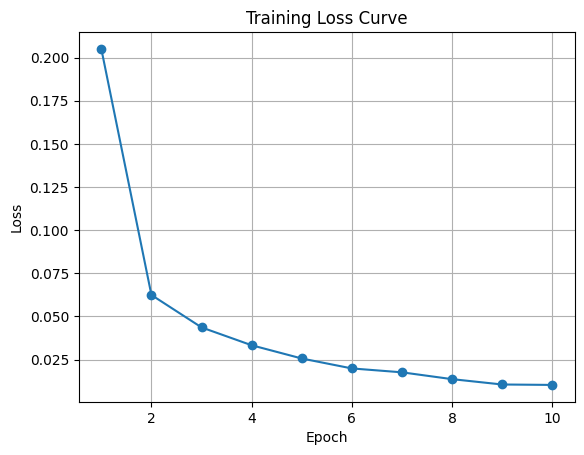

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_losses, marker='o')
plt.title("Training Loss Curve")   # 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [18]:
def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total   += labels.size(0)
    return correct / total

accuracy = evaluate(model, test_loader)
print(f"테스트 정확도: {accuracy*100:.2f}%")



테스트 정확도: 98.67%


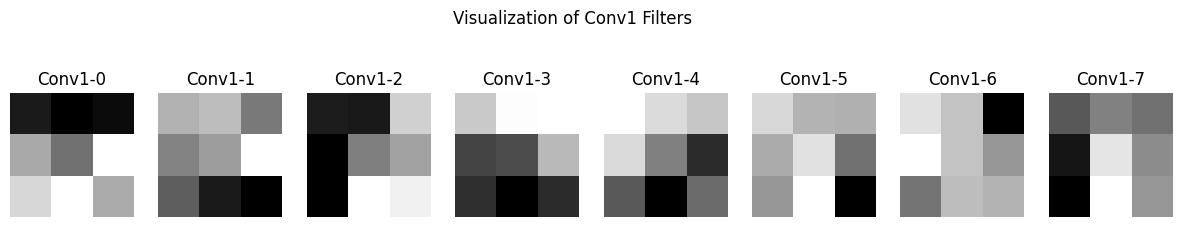

In [19]:
def visualize_conv1_filters(model):
    weights = model.conv1.weight.data.clone()

    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    for i in range(8):
        axes[i].imshow(weights[i][0].cpu(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Conv1-{i}')
    plt.suptitle("Visualization of Conv1 Filters")
    plt.show()

visualize_conv1_filters(model)



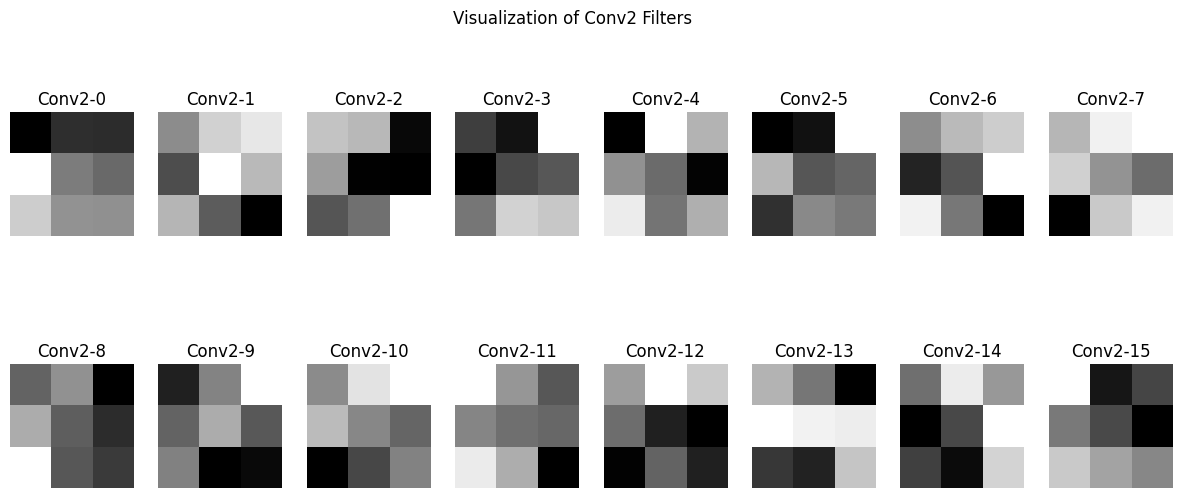

In [20]:
def visualize_conv2_filters(model):
    weights = model.conv2.weight.data.clone()

    fig, axes = plt.subplots(2, 8, figsize=(15, 6))
    for i in range(16):
        row, col = divmod(i, 8)
        axes[row, col].imshow(weights[i][0].cpu(), cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'Conv2-{i}')
    plt.suptitle("Visualization of Conv2 Filters")
    plt.show()

visualize_conv2_filters(model)



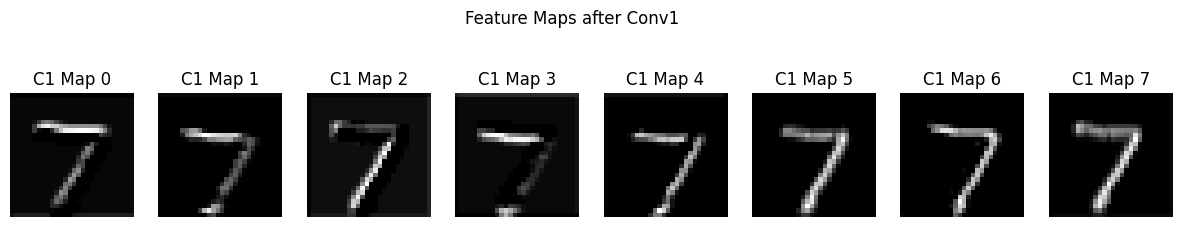

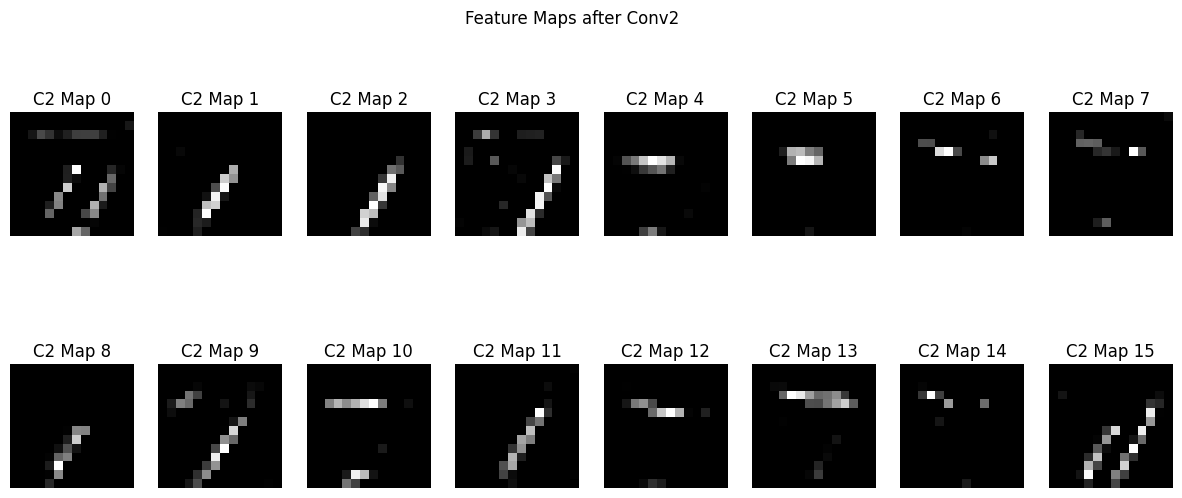

In [21]:
import torch.nn.functional as F

def visualize_feature_maps(model, image_tensor):
    model.eval()
    with torch.no_grad():
        x = image_tensor.unsqueeze(0).to(device)  # [1, 1, 28, 28]

        # Conv1 통과
        conv1_out = F.relu(model.conv1(x))        # [1, 8, 28, 28]
        conv1_maps = conv1_out.squeeze(0).cpu()

        # Conv2 통과 (Conv1 + Pool 이후)
        x_pooled = model.pool(conv1_out)          # [1, 8, 14, 14]
        conv2_out = F.relu(model.conv2(x_pooled)) # [1, 16, 14, 14]
        conv2_maps = conv2_out.squeeze(0).cpu()

    # Conv1 Feature Maps
    fig, axes = plt.subplots(1, 8, figsize=(15, 3))
    for i in range(8):
        axes[i].imshow(conv1_maps[i], cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'C1 Map {i}')
    plt.suptitle("Feature Maps after Conv1")
    plt.show()

    # Conv2 Feature Maps
    fig, axes = plt.subplots(2, 8, figsize=(15, 6))
    for i in range(16):
        row, col = divmod(i, 8)
        axes[row, col].imshow(conv2_maps[i], cmap='gray')
        axes[row, col].axis('off')
        axes[row, col].set_title(f'C2 Map {i}')
    plt.suptitle("Feature Maps after Conv2")
    plt.show()

# 테스트셋 샘플 하나
sample_image, _ = test_dataset[0]
visualize_feature_maps(model, sample_image)



In [12]:
class CNNWithRegularization(nn.Module):
    def __init__(self):
        super(CNNWithRegularization, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(8)
        
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)  # 합성곱 계층 뒤 Dropout
        
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.bn_fc1 = nn.BatchNorm1d(128)
        self.dropout_fc = nn.Dropout(0.5)  # 완전연결층에서는 더 강한 Dropout
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # Conv1 + BN + ReLU + Pool
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # Conv2 + BN + ReLU + Pool
        x = self.dropout(x)

        x = x.view(x.size(0), -1)                       # Flatten
        x = F.relu(self.bn_fc1(self.fc1(x)))            # FC1 + BN + ReLU
        x = self.dropout_fc(x)
        x = self.fc2(x)
        return x

# 모델 생성 및 디바이스 할당
model = CNNWithRegularization().to(device)


[BN+Dropout] Epoch 1/10, Loss: 0.2662
[BN+Dropout] Epoch 2/10, Loss: 0.1141
[BN+Dropout] Epoch 3/10, Loss: 0.0911
[BN+Dropout] Epoch 4/10, Loss: 0.0826
[BN+Dropout] Epoch 5/10, Loss: 0.0728
[BN+Dropout] Epoch 6/10, Loss: 0.0659
[BN+Dropout] Epoch 7/10, Loss: 0.0640
[BN+Dropout] Epoch 8/10, Loss: 0.0615
[BN+Dropout] Epoch 9/10, Loss: 0.0570
[BN+Dropout] Epoch 10/10, Loss: 0.0542
Test Accuracy with BN+Dropout: 99.22%


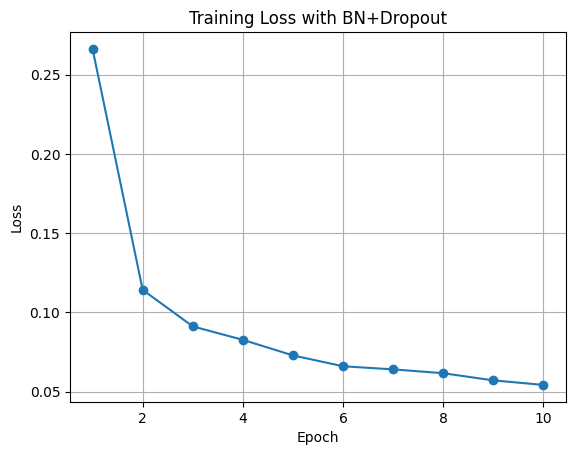

In [13]:
# Dropout + BatchNorm이 포함된 모델 생성
model = CNNWithRegularization().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
train_losses_reg = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses_reg.append(avg_loss)
    print(f"[BN+Dropout] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# 테스트 정확도 평가
accuracy_reg = evaluate(model, test_loader)
print(f"Test Accuracy with BN+Dropout: {accuracy_reg*100:.2f}%")

# 손실 곡선 시각화
plt.plot(range(1, num_epochs+1), train_losses_reg, marker='o')
plt.title("Training Loss with BN+Dropout")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

